In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joiningFunctions as jf
from matplotlib.legend_handler import HandlerLine2D
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time

%matplotlib inline

In [2]:
train_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_train.csv', index_col=0)
test_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test1.csv', index_col=0)
submit1_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test2.csv', index_col=0)
submit2_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test3.csv', index_col=0)
nypd_complaints = pd.read_csv('2018_NYPD_Complaints.csv', index_col=0)
zip_incident =  pd.read_csv('zip_incident_df.csv',index_col=0)

In [3]:
train_df = jf.joinRentNYPD(train_df, nypd_complaints)
train_df = jf.jointRent311(train_df, zip_incident)

test_df = jf.joinRentNYPD(test_df, nypd_complaints)
test_df = jf.jointRent311(test_df, zip_incident)

submit1_df = jf.joinRentNYPD(submit1_df, nypd_complaints)
submit1_df = jf.jointRent311(submit1_df, zip_incident)

submit2_df = jf.joinRentNYPD(submit2_df, nypd_complaints)
submit2_df = jf.jointRent311(submit2_df, zip_incident)

train_df.columns

Index(['addr_unit', 'building_id', 'bedrooms', 'bathrooms', 'size_sqft',
       'created_at', 'addr_street', 'addr_city', 'addr_zip', 'addr_lat',
       'addr_lon', 'bin', 'bbl', 'floor_count', 'year_built', 'min_to_subway',
       'has_doorman', 'has_elevator', 'has_fireplace', 'has_dishwasher',
       'is_furnished', 'has_gym', 'allows_pets', 'has_washer_dryer',
       'has_garage', 'has_roofdeck', 'has_concierge', 'has_pool', 'has_garden',
       'has_childrens_playroom', 'rent', 'no_fee', 'description',
       'neighborhood', 'borough', 'unit', 'floornumber', 'line', 'precinct',
       'petit_larceny', 'harrassment_2', 'assault_3', 'criminal_mischief',
       'grand_larceny', 'public_order', 'felony_assault', 'dangerous_drugs',
       'penal_law', 'robbery', 'burglary', 'misdemenor', 'felony', 'violation',
       'Number of Incidents'],
      dtype='object')

In [4]:
train_df.shape

(12000, 54)

In [5]:
test_df.shape

(2000, 54)

In [6]:
train_df.sample(5).transpose()

,11068,11320,1123,2875,1553
addr_unit,#6H,#5N,#4F,#18A,#609
building_id,541786,54361,13750,16666,18771901
bedrooms,2,2,1,0,2
bathrooms,2,2,1,1,1
size_sqft,1100,1100,500,275,814
created_at,2018-05-30 11:07:38,2018-05-03 19:18:34,2018-05-18 11:53:45,2018-07-20 16:06:47,2018-06-29 10:03:05
addr_street,590 FLATBUSH AVENUE,803 9 AVENUE,103 ALLEN STREET,57 EAST 7 STREET,280 ASHLAND PLACE
addr_city,Brooklyn,New York,New York,New York,Brooklyn
addr_zip,11225,10019,10002,10003,11217
addr_lat,40.659,40.7657,40.719,40.7278,40.687


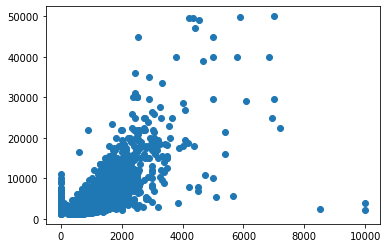

In [7]:
plt.scatter(train_df['size_sqft'],train_df['rent'])

In [8]:
#Had to remove features with strings as the type i.e. 'addr_city', 'neighborhood', 'borough'
#Might have to try turning them into numbers to find out how important they are
features = ['bedrooms', 'bathrooms', 'size_sqft', 'addr_zip', 'bin', 'bbl',
                    'floor_count', 'has_doorman', 'has_elevator',
                    'has_fireplace', 'has_dishwasher','is_furnished', 'has_gym', 'allows_pets',
                    'has_washer_dryer', 'has_garage', 'has_roofdeck', 'has_concierge', 'has_pool',
                    'precinct', 'petit_larceny', 'harrassment_2', 'assault_3', 'criminal_mischief',
                    'grand_larceny', 'public_order', 'felony_assault', 'dangerous_drugs', 'penal_law',
                    'robbery', 'burglary', 'misdemenor', 'felony', 'violation', 'has_garden', 
                    'has_childrens_playroom', 'Number of Incidents', 'no_fee', 'rent']

#Most important features (comment it out to test every feature)
# features = ['size_sqft', 'bbl', 'bathrooms', 'bedrooms', 'rent']

print('Train NaNs:', train_df[features].isna().sum(), sep='\n')
print('\n')
print('Test NaNs:', test_df[features].isna().sum(), sep='\n')

train_features = train_df[features].dropna()
train_target = train_features['rent']
train_features = train_features.drop(labels='rent', axis=1)
test_features = test_df[features]
test_target = test_features['rent']
test_features = test_features.drop(labels='rent', axis=1)

Train NaNs:
bedrooms                  0
bathrooms                 0
size_sqft                 0
addr_zip                  0
bin                       1
bbl                       0
floor_count               0
has_doorman               0
has_elevator              0
has_fireplace             0
has_dishwasher            0
is_furnished              0
has_gym                   0
allows_pets               0
has_washer_dryer          0
has_garage                0
has_roofdeck              0
has_concierge             0
has_pool                  0
precinct                  0
petit_larceny             0
harrassment_2             0
assault_3                 0
criminal_mischief         0
grand_larceny             0
public_order              0
felony_assault            0
dangerous_drugs           0
penal_law                 0
robbery                   0
burglary                  0
misdemenor                0
felony                    0
violation                 0
has_garden                0
has_chil

In [9]:
# Checking if there are any missing values for the features in the test2.csv set
print('test2.csv NaNs:', submit1_df[features].isna().sum(), sep='\n')

test2.csv NaNs:
bedrooms                     0
bathrooms                    0
size_sqft                    0
addr_zip                     0
bin                          0
bbl                          0
floor_count                  0
has_doorman                  0
has_elevator                 0
has_fireplace                0
has_dishwasher               0
is_furnished                 0
has_gym                      0
allows_pets                  0
has_washer_dryer             0
has_garage                   0
has_roofdeck                 0
has_concierge                0
has_pool                     0
precinct                     0
petit_larceny                0
harrassment_2                0
assault_3                    0
criminal_mischief            0
grand_larceny                0
public_order                 0
felony_assault               0
dangerous_drugs              0
penal_law                    0
robbery                      0
burglary                     0
misdemenor             

In [10]:
# Checking if there are any missing values for the features in the test2.csv set
print('test3.csv NaNs:', submit2_df[features].isna().sum(), sep='\n')

test3.csv NaNs:
bedrooms                     0
bathrooms                    0
size_sqft                    0
addr_zip                     0
bin                          2
bbl                          0
floor_count                  0
has_doorman                  0
has_elevator                 0
has_fireplace                0
has_dishwasher               0
is_furnished                 0
has_gym                      0
allows_pets                  0
has_washer_dryer             0
has_garage                   0
has_roofdeck                 0
has_concierge                0
has_pool                     0
precinct                     0
petit_larceny                0
harrassment_2                0
assault_3                    0
criminal_mischief            0
grand_larceny                0
public_order                 0
felony_assault               0
dangerous_drugs              0
penal_law                    0
robbery                      0
burglary                     0
misdemenor             

In [11]:
submit2_features = submit2_df[features].drop(labels='rent', axis=1)
submit2_features.isnull().sum().sum()

2

In [12]:
submit2_features['bin'].fillna(1000000.0, inplace = True)

In [13]:
submit2_features.isnull().sum().sum()

0

In [14]:
# Checking if there is anymore null values
submit2_features[submit2_features['bin'].isnull()]

,bedrooms,bathrooms,size_sqft,addr_zip,bin,bbl,floor_count,has_doorman,has_elevator,has_fireplace,...,penal_law,robbery,burglary,misdemenor,felony,violation,has_garden,has_childrens_playroom,Number of Incidents,no_fee


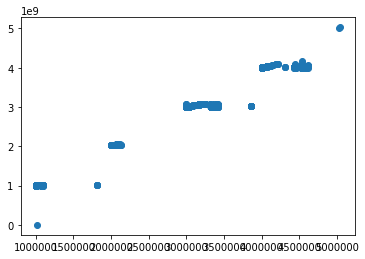

In [15]:
plt.scatter(test_df['bin'],test_df['bbl'])

In [16]:
#zip codes missing from the join function will go back and add these.
print(test_features.loc[test_features.precinct.isna(), 'addr_zip'])
print(submit1_df.loc[submit1_df.precinct.isna(), 'addr_zip'])
print(submit2_df.loc[submit2_df.precinct.isna(), 'addr_zip'])

Series([], Name: addr_zip, dtype: int64)
Series([], Name: addr_zip, dtype: int64)
Series([], Name: addr_zip, dtype: int64)


In [17]:
# fits estimator to training set and predicts on test1.csv features
# prints out MSE of predictions against test1.csv
# also calculates and prints std dev & mean of 5-fold CV  on training set
def getResults(estimator):
    estimator.fit(train_features, train_target)
    test_pred = estimator.predict(test_features)
    cv_results = cross_val_score(estimator, train_features, train_target, cv=5, scoring='neg_mean_squared_error')
    print('Mean Squared Error: ', mean_squared_error(test_target, test_pred))
    print("CV Results (Std Dev): ", np.std(cv_results))
    print("CV Results (Mean): ", np.mean(cv_results))


#To get the feature importances for linear regression scale the features and then use .coef_
#importances for lr are in magnitude while others are in percentage
#I haven't scaled the features so this code doesn't really tell you much
def getImportances(estimator):
    importances = estimator.coef_ if isinstance(estimator, LinearRegression) else estimator.feature_importances_*100
    print('\nFeature Importances')
    for i in range(len(importances)):
        print(features[i], importances[i])

In [18]:
lr = LinearRegression()
dt = DecisionTreeRegressor()
gb = GradientBoostingRegressor()
rf = RandomForestRegressor()

names = ['\nLinear Regression', '\nDecision Tree Regressor', '\nGradient Boosting Regressor', '\nRandom Forest Regressor']
estimators = [lr, dt, gb, rf]

for i in range(len(names)):
    print(names[i])
    getResults(estimators[i])
    getImportances(estimators[i])


Linear Regression
Mean Squared Error:  3180974.059227608
CV Results (Std Dev):  679826.8874929545
CV Results (Mean):  -3074207.412479802

Feature Importances
bedrooms 299.2918107727239
bathrooms 1306.79812099945
size_sqft 2.317321768140859
addr_zip -0.4513331966483444
bin 0.00016881718661667568
bbl -4.5001270585715537e-07
floor_count -3.427966302256704
has_doorman 73.55686333359941
has_elevator 287.23296710128284
has_fireplace 531.8441537852254
has_dishwasher -201.4561194931414
is_furnished 850.4989582426184
has_gym 331.7248126454218
allows_pets 203.22504678788883
has_washer_dryer 402.34785781113703
has_garage -177.3606417817783
has_roofdeck 188.18340964041022
has_concierge 206.33666301209274
has_pool 218.43410583953715
precinct -0.5890077465468202
petit_larceny -2.619818917331821
harrassment_2 6.175463679165936
assault_3 -1.9701966923328815
criminal_mischief -4.007469567559475
grand_larceny -0.09614679446473043
public_order -2.7084714725677848
felony_assault -2.2824091646736036
dange

C:\Users\Garland\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Mean Squared Error:  1690915.3515432088
CV Results (Std Dev):  285407.3534439984
CV Results (Mean):  -1301764.8911119797

Feature Importances
bedrooms 1.378416606099709
bathrooms 11.217755810334435
size_sqft 57.08486125539238
addr_zip 1.3073883916846736
bin 1.4525718605705493
bbl 11.415504070747165
floor_count 1.5393284242296197
has_doorman 0.203567186232606
has_elevator 0.27020461173923943
has_fireplace 0.40332445305080344
has_dishwasher 0.6265350615164734
is_furnished 0.5016547126828773
has_gym 0.609540365342245
allows_pets 0.27234592113622236
has_washer_dryer 0.466289117230147
has_garage 0.1086157369628168
has_roofdeck 0.3216534734780797
has_concierge 0.14306243686565942
has_pool 0.150875404454403
precinct 2.819326912011919
petit_larceny 0.6372136119913412
harrassment_2 0.15475017932488747
assault_3 0.21931267380236635
criminal_mischief 0.20812003483063704
grand_larceny 2.915433182405472
public_order 0.15916629852784453
felony_assault 0.13669879941407942
dangerous_drugs 0.4004374707

GradientBoostingRegressor or RandomForestRegressor seems to give us the best score so far, further testing with hyperparameters is needed

In [14]:
def testHyperparameter(param_grid):
    results = {}
    hp_name = list(param_grid.keys())[0]
    hp_values = list(param_grid.values())[0]
    
    # Create decision tree model and tune hyperparameter using GridSearchCV
    decision_tree = DecisionTreeRegressor()
    dt_cv = GridSearchCV(dt, param_grid, cv=5)
    dt_cv.fit(train_features, train_target)
    results['best_param'] = dt_cv.best_params_
    results['best_score'] = dt_cv.best_score_
    
    # Grab mean test/train score of 5 splits
    mean_test = dt_cv.cv_results_['mean_test_score']
    mean_train = dt_cv.cv_results_['mean_train_score']

    # Plot mean test/train AUC score against hyperparameter values
    line1, = plt.plot(hp_values, mean_test, 'b', label='Test AUC')
    line2, = plt.plot(hp_values, mean_train, 'r', label='Train AUC')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC Score')
    plt.xlabel(hp_name)
    plt.show()
    
    print(results)

In [15]:
# Tuning individual hyperparameters for decision tree regressor 
param_grids = []

# Hyperparameter 1: max_depth -> indicates depth of tree; 
# Testing range of 1 to 32
max_depth_values = np.arange(1, 33)
param_grids.append({'max_depth': max_depth_values})

# Hyperparameter 2: min_samples_split <- minimum number of samples required to split a node
# Testing range from 10% to 100%
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)
param_grids.append({'min_samples_split': min_samples_split})

# Hyperparameter 3: min_samples_leaf <- minimum number of samples required at each leaf node
# Testing range from 10% to 50%
min_samples_leaf = np.linspace(0.1, 0.5, 10, endpoint=True)
param_grids.append({'min_samples_leaf': min_samples_leaf})

# Hyperparameter 4: max_features <- max number of features to test
# Testing range from 1 to 1 less than the number of features in the df
max_features = list(range(1,train_features.shape[1]))
param_grids.append({'max_features': max_features})

for hyperparameter in param_grids:
    testHyperparameter(hyperparameter)


KeyError: 'mean_train_score'

In [16]:
# Testing all 4 hyperparameters together to find the best combination
param_grid = {
              "min_samples_split": [10, 20, 40, 80, 160],
              "max_depth": [2, 6, 8, 10, 15, 20, 30, 40, 50],
              "min_samples_leaf": [20, 40, 100, 200, 400],
              "max_leaf_nodes": [5, 20, 100, 200, 500]
              }

dtr = DecisionTreeRegressor()
dtr_cv = RandomizedSearchCV(dtr, param_grid, cv=5, n_iter = 1000, n_jobs=-1)
dtr_cv.fit(train_features, train_target)
print(dtr_cv.best_params_)
print(dtr_cv.best_score_)
print(dtr_cv.best_estimator_)

{'min_samples_split': 40, 'min_samples_leaf': 20, 'max_leaf_nodes': 500, 'max_depth': 40}
0.7725253309879045
DecisionTreeRegressor(criterion='mse', max_depth=40, max_features=None,
                      max_leaf_nodes=500, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=20,
                      min_samples_split=40, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')


In [17]:
# Results of predicting rent on test set using optimized decision tree
optimized_dt = dtr_cv.best_estimator_
test_pred = optimized_dt.predict(test_features)
cv_results = cross_val_score(optimized_dt, train_features, train_target, cv=5, scoring = 'neg_mean_squared_error')
print('DecisionTreeRegressor')
print('Mean Squared Error: ', mean_squared_error(test_target, test_pred))
print("CV Results: ", cv_results)
print("Mean CV Results: ", np.mean(cv_results))

DecisionTreeRegressor
Mean Squared Error:  2508129.459082569
CV Results:  [-2069187.20335822 -1978935.93174218 -2357439.87089284 -1512475.30595236
 -1498009.64887676]
Mean CV Results:  -1883209.592164471


In [19]:
rf = RandomForestRegressor(random_state = 42)

# not too important to care about. just wanted to see parameters inside
from pprint import pprint

pprint(rf.get_params())

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [20]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 50]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 16, 32]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 8, 16, 32],
 'min_samples_split': [2, 5, 10, 20, 50],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [21]:
#Random Search Training
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50,
                              cv = 5, random_state = 42, n_jobs = -1)

rf_random.fit(train_features, train_target)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [22]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': False}

Now testing optimized random forest

In [23]:
optimized_rf =  rf_random.best_estimator_
test_pred = optimized_rf.predict(test_features)
cv_results = cross_val_score(optimized_rf, train_features, train_target, cv=5, scoring = 'neg_mean_squared_error')
print('Mean Squared Error: ', mean_squared_error(test_target, test_pred))
print("CV Results: ", cv_results)
print("Mean CV Results: ", np.mean(cv_results))

#Mean Squared Error slightly decreases.

Mean Squared Error:  1586317.6677488303
CV Results:  [-1515634.0809642   -856641.34880255 -1332940.63733162 -1104520.17186467
  -569939.25852185]
Mean CV Results:  -1075935.0994969807


In [24]:
test_pred

array([ 2581.231     ,  2115.0815    ,  2933.0955    , ...,
       14966.431     ,  3594.32      ,  2835.44166667])

In [25]:
test_rental_id = test_df.iloc[:,0]
print(test_rental_id)

0           #1B
1           #C4
2       #GARDEN
3           #2C
4            #9
         ...   
1995        #4H
1996       #11K
1997       #44A
1998       #15M
1999         #3
Name: addr_unit, Length: 2000, dtype: object


In [26]:
# checking for any missing values in test3.csv
submit2_features.isnull().sum().sum()

0

In [27]:
submit2_features[submit2_features['bin'].isnull()]

,bedrooms,bathrooms,size_sqft,addr_zip,bin,bbl,floor_count,has_doorman,has_elevator,has_fireplace,...,penal_law,robbery,burglary,misdemenor,felony,violation,has_garden,has_childrens_playroom,Number of Incidents,no_fee


In [38]:
# Create submission file for test2.csv (Commented out so the .csv doesn't get overwritten)
#submit1_df['predictions'] = optimized_rf.predict(submit1_features)
#submit1_df['predictions'].to_csv('test2_submission.csv', header=True)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [28]:
# Checking feature importance for optimized random forest
getImportances(optimized_rf)


Feature Importances
bedrooms 8.075617862824672
bathrooms 20.233043237023736
size_sqft 29.489509042937744
addr_zip 3.1219921771479573
bin 3.919262930666853
bbl 6.43746905451353
floor_count 2.51174569088846
has_doorman 0.7444095630821111
has_elevator 0.7201213878638644
has_fireplace 0.37898076577235856
has_dishwasher 0.8842519764552328
is_furnished 0.6128651080079618
has_gym 0.7317171026956646
allows_pets 0.4203396523674855
has_washer_dryer 3.376902441669068
has_garage 0.21533041363453528
has_roofdeck 0.5955063951093194
has_concierge 0.709826566497936
has_pool 0.3838676309700687
precinct 3.3277617967442907
petit_larceny 0.6347341903296589
harrassment_2 0.4365809812373733
assault_3 0.521252287286668
criminal_mischief 0.885558311126352
grand_larceny 1.41188704677046
public_order 0.4231835257052865
felony_assault 0.7505653270032532
dangerous_drugs 0.5837657386867622
penal_law 1.6553284684070948
robbery 0.6770552218628956
burglary 0.44263515761670524
misdemenor 0.4391827265023041
felony 0.3